In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torchvision.transforms import RandomHorizontalFlip

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train

from util import load_Cifar10, show_samples, show_trajectories

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_Cifar10(batch_size, [1])
input_shape = (batch_size, 4, 32, 32)

def get_samples(shape, device):
    return torch.randn(shape, device=device)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([5000, 3, 32, 32])


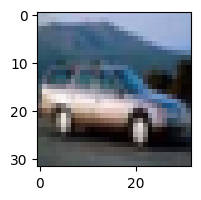

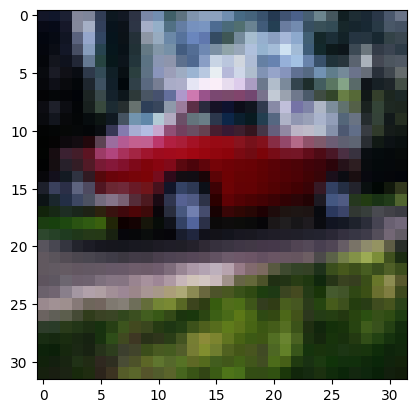

In [167]:
data = torch.tensor(train_dataset.data).permute([0,3,1,2])
print(data.shape)
plt.figure(figsize=(2,2))
plt.imshow(data[0].permute([1,2,0]))
plt.show()
hflipper = RandomHorizontalFlip(p=0.5)
transformed_imgs = hflipper(data)
plt.imshow(transformed_imgs[89].permute([1,2,0]))
plt.show()

In [5]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=3, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [6]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=2e-4, weight_decay=10e-5)
scheduler_1 = None #optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.9, patience=120, verbose=True)

In [187]:
optimizer_1.__setattr__("lr", 5e-5)

In [208]:
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.9, patience=300, verbose=True)

Epoch 00310: reducing learning rate of group 0 to 1.8000e-04.
Epoch 00992: reducing learning rate of group 0 to 1.6200e-04.
Epoch 01529: reducing learning rate of group 0 to 1.4580e-04.
Epoch 01830: reducing learning rate of group 0 to 1.3122e-04.
Epoch 02131: reducing learning rate of group 0 to 1.1810e-04.
Epoch 02432: reducing learning rate of group 0 to 1.0629e-04.
Epoch 03018: reducing learning rate of group 0 to 9.5659e-05.
Epoch 03319: reducing learning rate of group 0 to 8.6093e-05.
Epoch 03620: reducing learning rate of group 0 to 7.7484e-05.
Epoch 03921: reducing learning rate of group 0 to 6.9736e-05.
Epoch 04222: reducing learning rate of group 0 to 6.2762e-05.
Epoch 04523: reducing learning rate of group 0 to 5.6486e-05.
Epoch 04824: reducing learning rate of group 0 to 5.0837e-05.
Epoch 05125: reducing learning rate of group 0 to 4.5754e-05.
Epoch 05431: reducing learning rate of group 0 to 4.1178e-05.
Epoch 05732: reducing learning rate of group 0 to 3.7060e-05.
Epoch 06

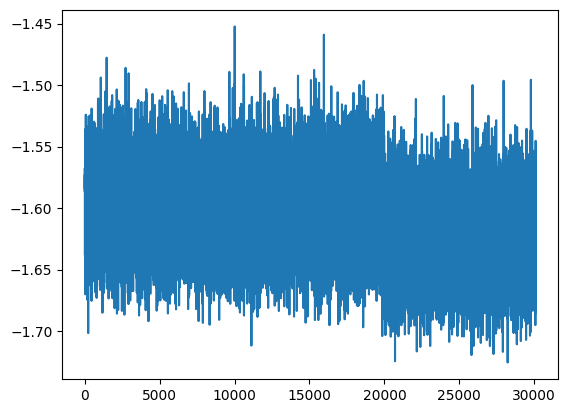

In [209]:
rectified_flow_1 = train(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader, get_samples, device, epochs=700, noise_factor=0.005, flip=True)
plt.plot(np.log(rectified_flow_1.loss_curve[100000:]))
plt.show()

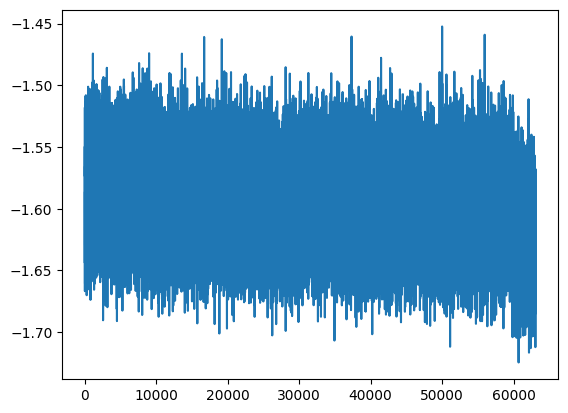

In [207]:
plt.plot(np.log(rectified_flow_1.loss_curve[60000:]))
plt.show()

In [553]:
torch.save(rectified_flow_1, "./models/CIFAR10/cifar10_car.pth")

In [4]:
rectified_flow_1 = torch.load("./models/CIFAR10/cifar10_car.pth")

In [168]:
def get_samples(shape, device):
    return torch.randn(shape, device=device)

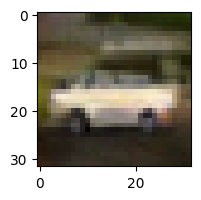

In [5]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(1,3,32,32).to(device) * 0.9
img = rectified_flow_1.sample_ode(img_init, 100)

# print(img[-1])

min = torch.min(img[-1][0])
img[-1][0] = img[-1][0] - min
max = torch.max(img[-1][0])
img[-1][0] = img[-1][0] / max

plt.figure(figsize=(2,2))
plt.imshow(img[-1][0].permute(1,2,0).detach().cpu().numpy())
plt.show()

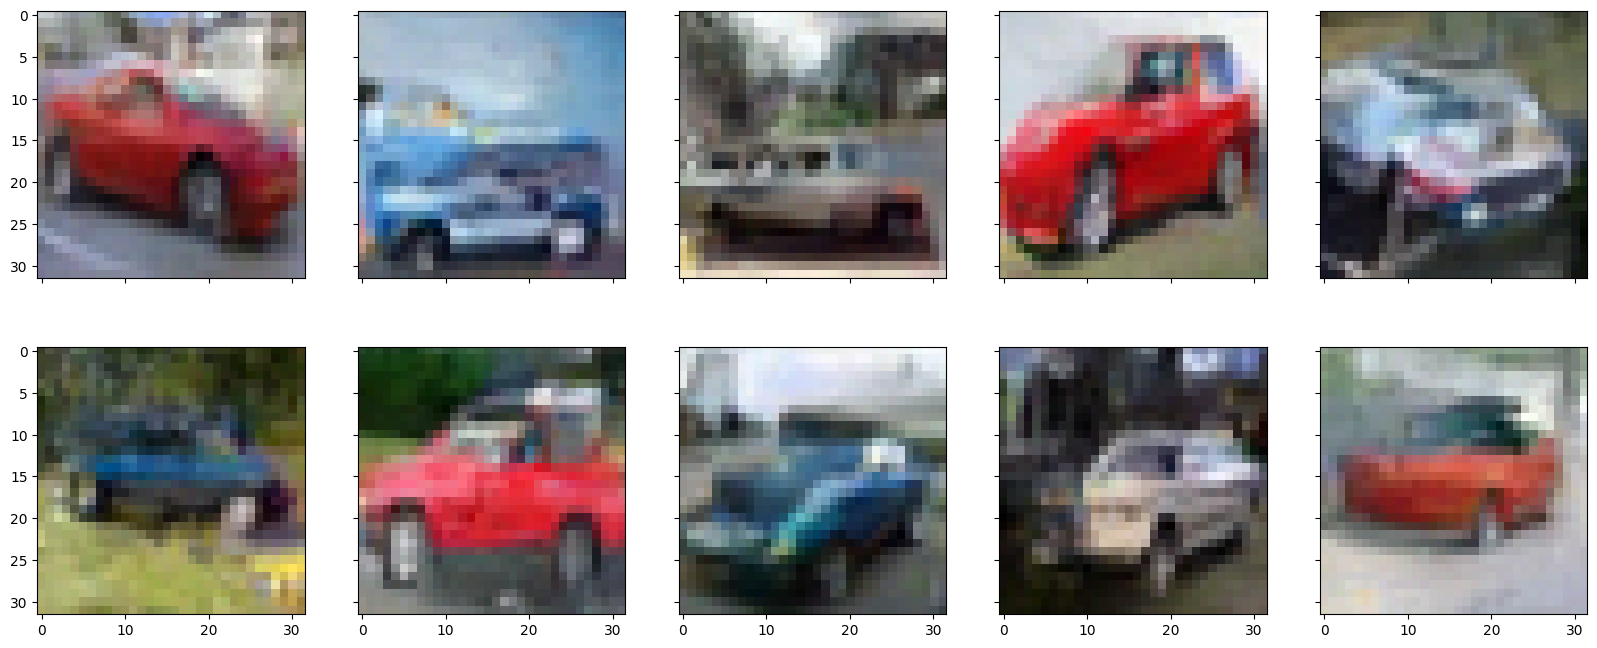

In [11]:
show_samples(rectified_flow_1, get_samples, columns=5, rows=2, channels=3, img_size=32, num_steps=100, device=device)

In [327]:
show_trajectories(rectified_flow_1, get_samples, img_size=32, num_steps=100, device=device)

RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[20, 2, 32, 32] to have 4 channels, but got 2 channels instead